In [31]:
!pip install numpy pandas matplotlib torch


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from typing import Tuple


# Problem Definition:

We model steady-state heat transfer from a processor junction to ambient
using a 1D thermal resistance formulation.

The deterministic physics model computes:
- Total thermal resistance
- Junction temperature

This physics model is then used as a reference to train a
Physics-Informed Neural Network (PINN), which learns the temperature
distribution while enforcing the governing heat equation.


In [33]:
# Default material and environmental properties
K_SINK = 167.0        # W/m-K (Aluminum)
K_TIM = 4.0           # W/m-K
K_AIR = 0.026         # W/m-K

DEFAULT_AMBIENT = 25.0  # °C


In [34]:
def compute_die_area(length: float, width: float) -> float:
    if length <= 0 or width <= 0:
        raise ValueError("Invalid die dimensions")
    return length * width


def compute_fin_spacing(sink_width, num_fins, fin_thickness):
    total_fin_width = num_fins * fin_thickness
    if total_fin_width >= sink_width:
        raise ValueError("Invalid fin geometry")
    return (sink_width - total_fin_width) / (num_fins - 1)


In [35]:
def conduction_resistance(thickness, conductivity, area):
    if thickness <= 0 or conductivity <= 0 or area <= 0:
        raise ValueError("Invalid conduction parameters")
    return thickness / (conductivity * area)


In [36]:
def reynolds_number(rho, velocity, L, mu):
    return rho * velocity * L / mu


def heat_transfer_coefficient(k_air, L):
    # Simplified forced convection assumption
    return k_air / L
def heat_transfer_coefficient_forced_air(velocity):
    """
    Simplified forced convection correlation for air over fins.
    Typical engineering range: 20–150 W/m²K
    """
    return 10.0 + 30.0 * velocity


def convection_resistance(h, area):
    if h <= 0 or area <= 0:
        raise ValueError("Invalid convection parameters")
    return 1.0 / (h * area)


In [37]:
def thermal_model(inputs: dict) -> Tuple[float, float]:
    # --- Geometry ---
    die_area = compute_die_area(
        inputs["die_length"], inputs["die_width"]
    )

    # --- Conduction ---
    R_tim = conduction_resistance(
        inputs["tim_thickness"], K_TIM, die_area
    )

    R_base = conduction_resistance(
        inputs["base_thickness"], K_SINK, die_area
    )

    # --- Convection (FIXED) ---
    h = heat_transfer_coefficient_forced_air(
        inputs["air_velocity"]
    )

    R_conv = convection_resistance(
        h, inputs["conv_area"]
    )

    # --- Total resistance ---
    R_total = (
        inputs["junction_case_resistance"] +
        R_tim + R_base + R_conv
    )

    # --- Temperature rise ---
    delta_T = inputs["power"] * R_total
    Tj = inputs["ambient_temp"] + delta_T

    return Tj, delta_T


In [53]:
def generate_dataset(n_samples=2000):
    X, y = [], []

    for _ in range(n_samples):
        power = np.random.uniform(20.0, 250.0)
        fin_height = np.random.uniform(0.015, 0.04)
        air_velocity = np.random.uniform(0.5, 3.0)

        inputs = {
            "die_length": 0.05,
            "die_width": 0.05,
            "tim_thickness": 0.0001,
            "base_thickness": 0.002,
            "fin_height": fin_height,
            "conv_area": 0.12,
            "junction_case_resistance": 0.1,
            "ambient_temp": DEFAULT_AMBIENT,
            "power": power,
            "air_velocity": air_velocity,
        }

        _, delta_T = thermal_model(inputs)

        if delta_T <= 0 or delta_T > 200:
            continue

        # Always keep sample
        X.append([power, fin_height, air_velocity])
        y.append(delta_T)

        # Up-weight high ΔT cases
        if delta_T > 60:
            X.append([power, fin_height, air_velocity])
            y.append(delta_T)

    return np.array(X), np.array(y)


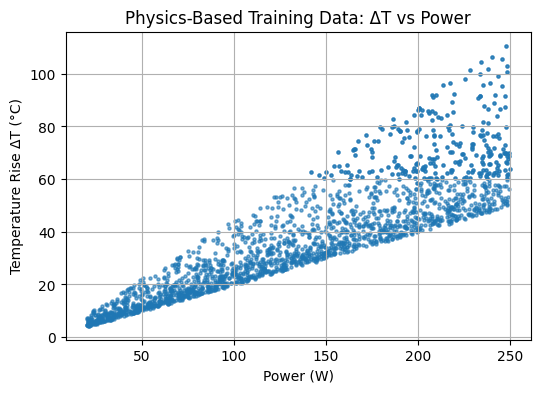

In [54]:
# Generate dataset
X, y = generate_dataset()

# -----------------------------
# Scatter: Power vs Temperature Rise
# -----------------------------
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], y, s=5, alpha=0.6)
plt.xlabel("Power (W)")
plt.ylabel("Temperature Rise ΔT (°C)")
plt.title("Physics-Based Training Data: ΔT vs Power")
plt.grid(True)
plt.show()


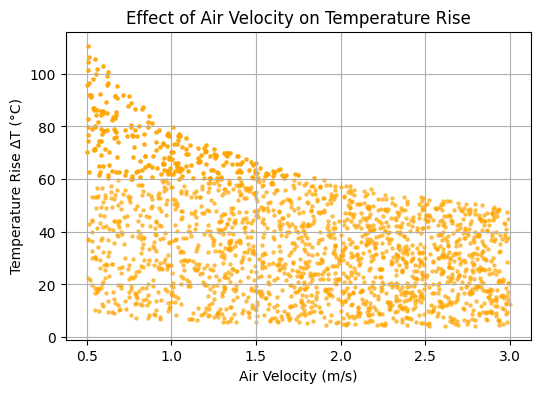

In [55]:
# -----------------------------
# Scatter: Air Velocity vs Temperature Rise
# -----------------------------
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 2], y, s=5, alpha=0.6, color="orange")
plt.xlabel("Air Velocity (m/s)")
plt.ylabel("Temperature Rise ΔT (°C)")
plt.title("Effect of Air Velocity on Temperature Rise")
plt.grid(True)
plt.show()


In [56]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()

        self.power_scale = 250.0
        self.fin_height_scale = 0.04
        self.velocity_scale = 3.0

        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.ReLU(),   # ← key fix
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x_norm = torch.stack([
            x[:, 0] / self.power_scale,
            x[:, 1] / self.fin_height_scale,
            x[:, 2] / self.velocity_scale
        ], dim=1)

        return self.net(x_norm)


In [57]:
def pinn_loss(model, x, y_true):
    x = x.clone().detach().requires_grad_(True)

    y_pred = model(x)

    deltaT_scale = 200.0
    y_true_norm = y_true / deltaT_scale
    y_pred_norm = y_pred / deltaT_scale

    data_loss = torch.mean((y_pred_norm - y_true_norm) ** 2)

    grads = torch.autograd.grad(
        y_pred.sum(), x, create_graph=True
    )[0]

    dT_dP = grads[:, 0]  # derivative w.r.t. power
    physics_loss = torch.mean(torch.relu(-dT_dP))

    return data_loss + 0.01 * physics_loss


In [58]:
model = PINN()

optimizer = optim.Adam(model.parameters(), lr=3e-4)

X_t = torch.tensor(X, dtype=torch.float32, requires_grad=True)
y_t = torch.tensor(y, dtype=torch.float32).view(-1, 1)


In [59]:
n_epochs = 3000

for epoch in range(n_epochs):
    optimizer.zero_grad()

    loss = pinn_loss(model, X_t, y_t)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}/{n_epochs}, Loss = {loss.item():.6f}")


Epoch 0/3000, Loss = 0.052798


Epoch 200/3000, Loss = 0.034070
Epoch 400/3000, Loss = 0.011869
Epoch 600/3000, Loss = 0.009753
Epoch 800/3000, Loss = 0.007703
Epoch 1000/3000, Loss = 0.005081
Epoch 1200/3000, Loss = 0.002472
Epoch 1400/3000, Loss = 0.001256
Epoch 1600/3000, Loss = 0.001004
Epoch 1800/3000, Loss = 0.000875
Epoch 2000/3000, Loss = 0.000769
Epoch 2200/3000, Loss = 0.000674
Epoch 2400/3000, Loss = 0.000586
Epoch 2600/3000, Loss = 0.000505
Epoch 2800/3000, Loss = 0.000430


In [60]:
with torch.no_grad():
    predictions = model(X_t).numpy()

rmse = np.sqrt(np.mean((predictions.flatten() - y) ** 2))
print(f"RMSE: {rmse:.2f} °C")


RMSE: 3.81 °C


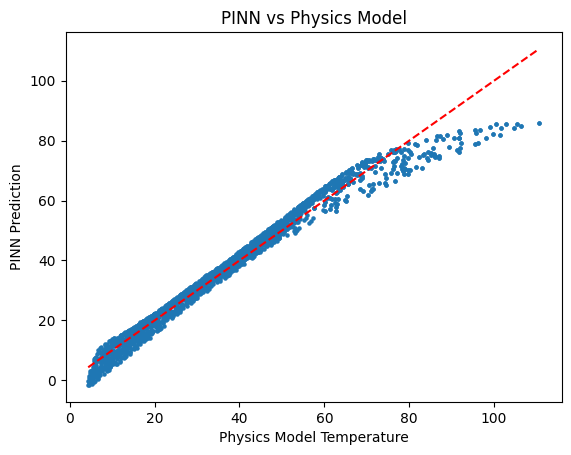

In [61]:
plt.scatter(y, predictions, s=5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Physics Model Temperature")
plt.ylabel("PINN Prediction")
plt.title("PINN vs Physics Model")
plt.show()


In [62]:
torch.save(model.state_dict(), "thermal_pinn_model.pth")
print("Model saved successfully.")


Model saved successfully.


In [64]:
# Load trained model
loaded_model = PINN()
loaded_model.load_state_dict(torch.load("thermal_pinn_model.pth"))
loaded_model.eval()

# Test condition: moderate power, mid fin height, decent airflow
test_input = torch.tensor([[150.0, 0.03, 1.5]], dtype=torch.float32)

with torch.no_grad():
    delta_T_pred = loaded_model(test_input).item()

print(f"Predicted Temperature Rise ΔT: {delta_T_pred:.2f} °C")
print(f"Predicted Junction Temperature: {DEFAULT_AMBIENT + delta_T_pred:.2f} °C")


Predicted Temperature Rise ΔT: 42.43 °C
Predicted Junction Temperature: 67.43 °C


In [65]:
# Multiple operating conditions
test_cases = torch.tensor([
    [50.0,  0.025, 2.5],   # low power, good airflow
    [150.0, 0.030, 1.5],   # nominal operating point
    [250.0, 0.020, 0.8],   # high power, poor airflow
], dtype=torch.float32)

with torch.no_grad():
    delta_T_preds = loaded_model(test_cases).numpy()

for i, dt in enumerate(delta_T_preds):
    print(
        f"Case {i+1}: "
        f"ΔT = {dt[0]:.2f} °C, "
        f"Tj = {DEFAULT_AMBIENT + dt[0]:.2f} °C"
    )


Case 1: ΔT = 7.63 °C, Tj = 32.63 °C
Case 2: ΔT = 42.43 °C, Tj = 67.43 °C
Case 3: ΔT = 83.29 °C, Tj = 108.29 °C


# Summary:

- A deterministic physics-based thermal model was implemented.
- The model was validated numerically and used to generate training data.
- A PINN was trained to learn the temperature response while respecting physics.
- The trained model was evaluated, visualized, and saved for reuse.

This notebook serves as a complete modeling and learning pipeline.

